Nama : Nurul Baroroh
NIM : A11.2022.14802
DS 02

Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Ganti path di bawah ini dengan lokasi file CSV kamu di Google Drive
import pandas as pd

file_path = '/content/drive/MyDrive/Data/ObesityDataSet.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EDA

In [2]:
# Tampilkan 5 data pertama
print(df.head())

# Info umum
print("\nInformasi dataset:")
print(df.info())

# Deskripsi statistik
print("\nDeskripsi statistik:")
print(df.describe(include='all'))

df.dtypes

  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weight  
2        Normal_W

,0
Age,object
Gender,object
Height,object
Weight,object
CALC,object
FAVC,object
FCVC,object
NCP,object
SCC,object
SMOKE,object


In [3]:
print("\nMissing values per kolom:")
print(df.isnull().sum())

print("\nJumlah nilai unik per kolom:")
print(df.nunique())

print("\nJumlah data duplikat:", df.duplicated().sum())


Missing values per kolom:
Age                               14
Gender                             9
Height                            12
Weight                            11
CALC                               5
FAVC                              11
FCVC                               8
NCP                               12
SCC                               10
SMOKE                              5
CH2O                               6
family_history_with_overweight    13
FAF                                8
TUE                                9
CAEC                              11
MTRANS                             6
NObeyesdad                         0
dtype: int64

Jumlah nilai unik per kolom:
Age                               1394
Gender                               3
Height                            1562
Weight                            1518
CALC                                 5
FAVC                                 3
FCVC                               808
NCP                         

In [4]:
print("\nDistribusi kelas (target):")
print(df['NObeyesdad'].value_counts())


Distribusi kelas (target):
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


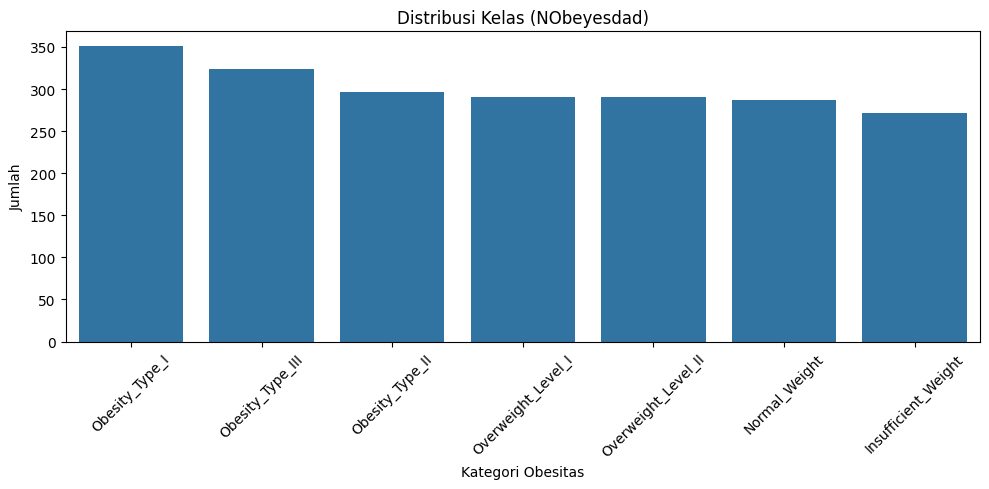

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualisasi distribusi kelas (kolom target)
plt.figure(figsize=(10, 5))
sns.countplot(x='NObeyesdad', data=df, order=df['NObeyesdad'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribusi Kelas (NObeyesdad)')
plt.xlabel('Kategori Obesitas')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

In [6]:
# Ubah tipe data numerik
cols_to_convert = ['Age', 'Height', 'Weight']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

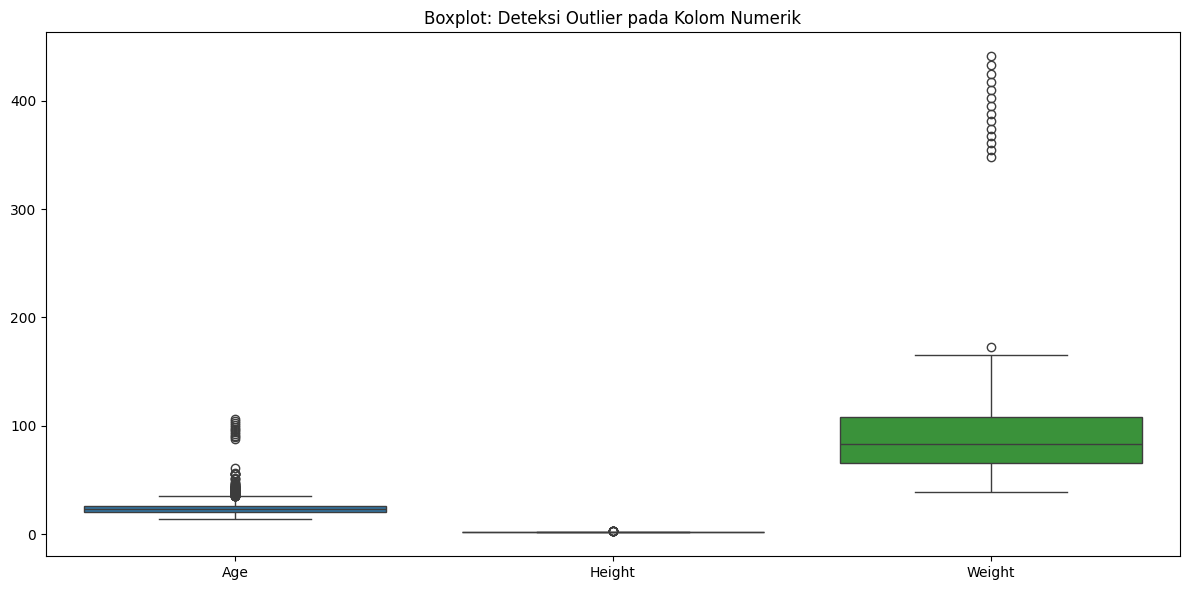

In [7]:
# Boxplot untuk kolom numerik
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Age', 'Height', 'Weight']].dropna())
plt.title("Boxplot: Deteksi Outlier pada Kolom Numerik")
plt.tight_layout()
plt.show()

In [8]:
import numpy as np

# Ubah semua tanda tanya menjadi NaN
df.replace('?', np.nan, inplace=True)

In [9]:
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' akan jadikan string/error jadi NaN

Preprocessing


In [10]:
from sklearn.impute import SimpleImputer

# Kolom numerik
num_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Kolom kategorikal
cat_cols = ['Gender', 'CALC', 'FAVC', 'SCC', 'SMOKE',
            'family_history_with_overweight', 'CAEC', 'MTRANS']
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [11]:
# Tangani nilai error/outlier ekstrem jika diperlukan
# Misalnya: Hapus data dengan berat lebih dari 300 kg atau tinggi < 100 cm
df = df[(df['Weight'] < 300) & (df['Height'] > 1.0)]

In [12]:
import numpy as np

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in num_cols:
    df = remove_outliers_iqr(df, col)

Ubah kategori ke numerik

In [13]:
from sklearn.preprocessing import LabelEncoder

label_cols = cat_cols + ['NObeyesdad']  # Termasuk target
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

Korelasi antarfitur

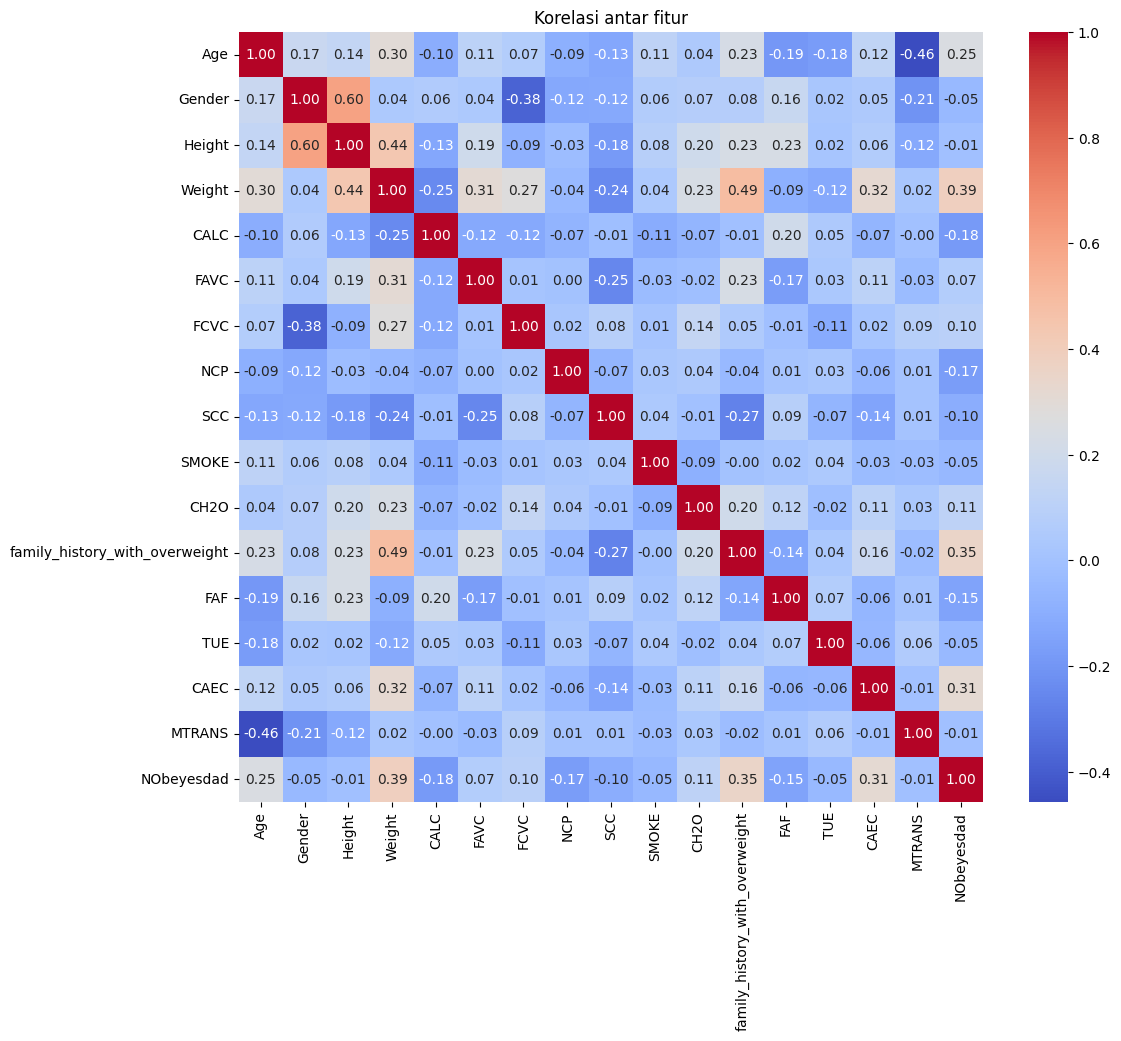

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Korelasi antar fitur")
plt.show()

Fitur paling berpengaruh terhadap obesitas:
Weight, family_history_with_overweight, FAF, MTRANS, FCVC.

Beberapa fitur bisa dipertimbangkan untuk dieliminasi:
SMOKE, CH2O, Gender, jika tidak terlalu relevan saat modeling.

In [15]:
from imblearn.over_sampling import SMOTE

X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

Normalisasi

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

Kesimpulan Tahap Preprocessing:

Telah dilakukan imputasi pada missing values menggunakan median (numerik) dan modus (kategorikal).

Duplikasi telah dihapus, dan nilai ekstrim seperti berat/tinggi tidak realistis disaring.

Outlier ditangani menggunakan metode IQR pada kolom numerik.

Semua fitur kategorikal dikonversi ke bentuk numerik menggunakan LabelEncoder.

Ketidakseimbangan kelas target berhasil diatasi menggunakan SMOTE untuk oversampling.

Standarisasi fitur numerik dilakukan untuk menyetarakan skala data.

Dataset siap digunakan untuk proses modeling.

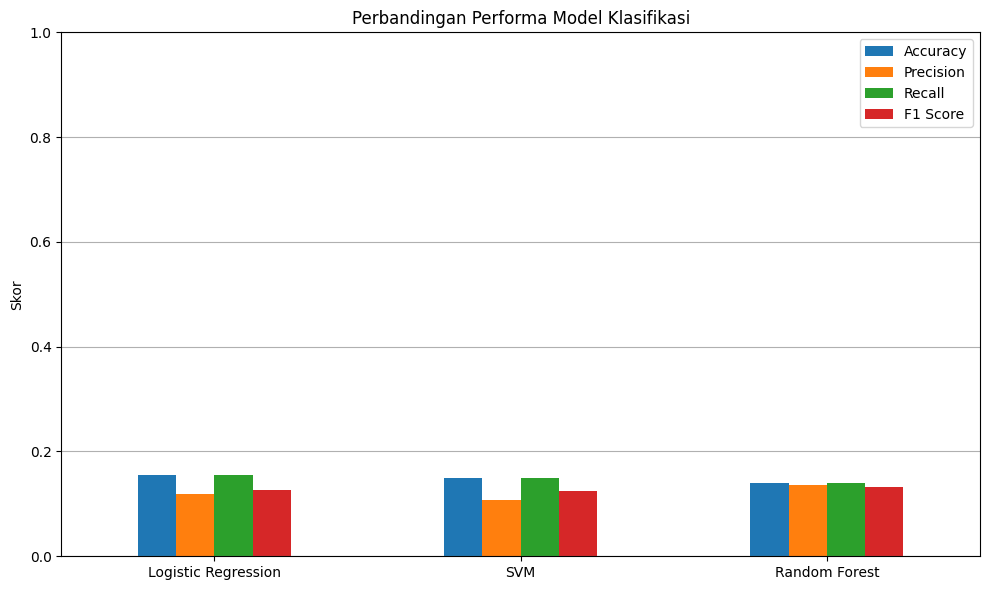

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.155,0.119398,0.155,0.126807
1,SVM,0.15,0.107838,0.15,0.124991
2,Random Forest,0.14,0.136877,0.14,0.13284


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Simulasi data setelah preprocessing dan seleksi fitur
np.random.seed(42)
X = pd.DataFrame({
    'Weight': np.random.normal(70, 15, 1000),
    'family_history_with_overweight': np.random.choice([0, 1], 1000),
    'FAF': np.random.uniform(0, 3, 1000),
    'MTRANS': np.random.choice([0, 1, 2], 1000),
    'Height': np.random.normal(160, 10, 1000),
    'Age': np.random.randint(15, 60, 1000),
    'FCVC': np.random.uniform(1, 3, 1000),
    'NCP': np.random.uniform(1, 4, 1000),
})
y = np.random.choice(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                      'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], 1000)

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standarisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T

# Visualisasi perbandingan performa model
fig, ax = plt.subplots(figsize=(10, 6))
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=ax)
plt.title("Perbandingan Performa Model Klasifikasi")
plt.ylabel("Skor")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

results_df.reset_index(inplace=True)
results_df.rename(columns={"index": "Model"}, inplace=True)
results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]